<a href="https://colab.research.google.com/github/vivek-a81/EVA6/blob/main/Session10/Assignment%20A/tiny_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!git clone https://github.com/MittalNeha/vision_pytorch.git

fatal: destination path 'vision_pytorch' already exists and is not an empty directory.


In [1]:
!pip install --upgrade albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.3)


In [2]:
!pip install torch-lr-finder

In [13]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgk8RyUHOD23tfo-fXt9ahrCiXmyRoAmlEAvPiqWc63y7V2KyyEH6Y
Mounted at /gdrive


In [14]:
!unzip -q /gdrive/MyDrive/EVA6/Session10/tiny-imagenet-200.zip 

In [3]:
import torch
from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

from vision_pytorch.dataloaders.tiny_image_net import get_id_dictionary, get_data, ImagenetDataset
from vision_pytorch.utils import datastats, lr_finder, plotting, dump_list
from vision_pytorch.models import resnet
from vision_pytorch.main import fit_model

from torch_lr_finder import LRFinder
import torch.nn as nn

In [16]:
# import Visionrepo
# import importlib
# importlib.reload(Visionrepo.dataloaders.tiny_image_net)
# from Visionrepo.dataloaders.tiny_image_net import ImagenetDataset

In [17]:
# importlib.reload(Visionrepo.models)
# from Visionrepo.main import fit_model

In [4]:

dataset_path = "/content/tiny-imagenet-200/"


In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print("CUDA Available:", use_cuda)
print("Selected Device:", device)
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=256
else:
    BATCH_SIZE=32
print("Batch Size", BATCH_SIZE)

CUDA Available: True
Selected Device: cuda
Batch Size 256


In [6]:
X_train, X_test, y_train, y_test = get_data(dataset_path)
# dataset = ImagenetDataset(X_train, y_train, train_transform)

starting loading data
finished loading data, in 0.12516236305236816 seconds
Samples for training: 70000
Samples for testing: 30000


In [7]:
exp_data = ImagenetDataset(X_train, y_train)
exp = torch.utils.data.DataLoader(exp_data , batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

mean, std = datastats.get_mean_std(exp)

The mean of dataset :  tensor([0.4803, 0.4482, 0.3976])
The std of dataset :  tensor([0.2766, 0.2691, 0.2819])


In [ ]:
# mean = np.array([0.4809, 0.4488, 0.3988])
# std = np.array([0.2766, 0.2690, 0.2824])

In [8]:
exp = torch.utils.data.DataLoader(ImagenetDataset(X_train, y_train) , batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# mean, std = get_mean_std(exp)

In [ ]:
# unique, counts = np.unique(y_test, return_counts=True)

In [ ]:
# plt.bar(unique, counts, 1 )
# plt.title('Class Frequency')
# plt.xlabel('Class')
# plt.ylabel('Frequency')


In [ ]:
plot_aug({
    'Original Image': None,
    'Random Crop': A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 2, keep_size=True by default
                  A.RandomCrop(64,64)]),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=24, max_width=24, min_holes=1, min_height=8, 
                               min_width=8, fill_value=([0.4803*255, 0.4482*255, 0.3976*255]), mask_fill_value=None, always_apply=True),
    'Horizontal Flip': A.HorizontalFlip(always_apply=True),
    'Vertical Flip': A.VerticalFlip(always_apply=True),
    'Rotate' :  A.Rotate(limit = 30, always_apply=True)
    
}, data=exp.dataset)

In [9]:
train_transform = A.Compose([
  
  A.PadIfNeeded(min_height=76, min_width=76, always_apply=True),
  A.RandomCrop(64,64),
  A.Rotate(limit=15),
  A.CoarseDropout(1,24, 24, 1, 8, 8,fill_value=[m*255 for m in mean], mask_fill_value=None),
  A.VerticalFlip(),
  A.HorizontalFlip(),
  A.Normalize(mean, std),
  ToTensorV2()
])

test_transform = A.Compose([
  A.Normalize(mean, std),
  ToTensorV2()
])

train_loader = torch.utils.data.DataLoader(ImagenetDataset(X_train, y_train, train_transform) , batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(ImagenetDataset(X_test, y_test, test_transform), batch_size=BATCH_SIZE,
                                           shuffle=False, num_workers=1)

In [10]:
net = resnet.ResNet18(num_classes=200).to(device)
summary(net, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.70E-01


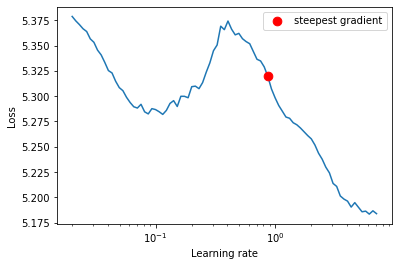

In [11]:

optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [12]:
ler_rate = 1.0

In [ ]:

optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
# schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=np.sqrt(0.1), cooldown=0, patience=2, min_lr=0.5e-6, verbose=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=50,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=True, 
                                                # final_div_factor=50,
                                                # anneal_strategy='linear'
                                                )
net, history = fit_model(
    net=net, device=device,
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    NUM_EPOCHS=50
)

  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.09999999999999998)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 4.7191, Accuracy: 1532/30000 (5.11%)

EPOCH: 2 (LR: 0.12204052018964329)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 4.3348, Accuracy: 2638/30000 (8.79%)

EPOCH: 3 (LR: 0.18600303840199484)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 3.9012, Accuracy: 4450/30000 (14.83%)

EPOCH: 4 (LR: 0.2856219227524337)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 3.6910, Accuracy: 5497/30000 (18.32%)

EPOCH: 5 (LR: 0.41113871976631267)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 3.4904, Accuracy: 6437/30000 (21.46%)

EPOCH: 6 (LR: 0.5502580716715264)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 3.1842, Accuracy: 8072/30000 (26.91%)

EPOCH: 7 (LR: 0.6893521434261327)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 3.1770, Accuracy: 8509/30000 (28.36%)

EPOCH: 8 (LR: 0.8147955763778335)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.9397, Accuracy: 9525/30000 (31.75%)

EPOCH: 9 (LR: 0.914300199341606)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.8270, Accuracy: 10240/30000 (34.13%)

EPOCH: 10 (LR: 0.97811875164458)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.7857, Accuracy: 10669/30000 (35.56%)

EPOCH: 11 (LR: 0.9999997039956104)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.7170, Accuracy: 11026/30000 (36.75%)

EPOCH: 12 (LR: 0.9777996449633134)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.6931, Accuracy: 11428/30000 (38.09%)

EPOCH: 13 (LR: 0.913693244989078)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.5104, Accuracy: 12395/30000 (41.32%)

EPOCH: 14 (LR: 0.8139602303080931)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.5107, Accuracy: 12491/30000 (41.64%)

EPOCH: 15 (LR: 0.6883702343588041)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.4327, Accuracy: 13051/30000 (43.50%)

EPOCH: 16 (LR: 0.5492257853249334)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.4134, Accuracy: 13224/30000 (44.08%)

EPOCH: 17 (LR: 0.41015717670962704)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3340, Accuracy: 13901/30000 (46.34%)

EPOCH: 18 (LR: 0.2847872728503567)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3164, Accuracy: 14135/30000 (47.12%)

EPOCH: 19 (LR: 0.18539704217905126)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3166, Accuracy: 14426/30000 (48.09%)

EPOCH: 20 (LR: 0.12172253974355138)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.2915, Accuracy: 14769/30000 (49.23%)

EPOCH: 21 (LR: 0.09999998539817982)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3380, Accuracy: 14691/30000 (48.97%)

EPOCH: 22 (LR: 0.09972218060912916)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3883, Accuracy: 14618/30000 (48.73%)

EPOCH: 23 (LR: 0.09889979637336167)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.4136, Accuracy: 14747/30000 (49.16%)

EPOCH: 24 (LR: 0.09754184071479619)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.4673, Accuracy: 14620/30000 (48.73%)

EPOCH: 25 (LR: 0.09566318806380358)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.5007, Accuracy: 14683/30000 (48.94%)

EPOCH: 26 (LR: 0.09328441632944298)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.5560, Accuracy: 14527/30000 (48.42%)

EPOCH: 27 (LR: 0.09043158149837921)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.6271, Accuracy: 14456/30000 (48.19%)

EPOCH: 28 (LR: 0.08713593222942277)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.6711, Accuracy: 14512/30000 (48.37%)

EPOCH: 29 (LR: 0.08343356756989435)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.6756, Accuracy: 14539/30000 (48.46%)

EPOCH: 30 (LR: 0.07936504154303357)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.7298, Accuracy: 14624/30000 (48.75%)

EPOCH: 31 (LR: 0.074974918937622)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.8037, Accuracy: 14540/30000 (48.47%)

EPOCH: 32 (LR: 0.07031128716549961)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.8271, Accuracy: 14624/30000 (48.75%)

EPOCH: 33 (LR: 0.065425229533866)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.8578, Accuracy: 14594/30000 (48.65%)

EPOCH: 34 (LR: 0.06037026570190255)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.9335, Accuracy: 14570/30000 (48.57%)

EPOCH: 35 (LR: 0.0552017654507002)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.9594, Accuracy: 14623/30000 (48.74%)

EPOCH: 36 (LR: 0.04997634218779073)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.9996, Accuracy: 14729/30000 (49.10%)

EPOCH: 37 (LR: 0.04475123282955817)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 3.0205, Accuracy: 14719/30000 (49.06%)

EPOCH: 38 (LR: 0.03958367085401716)


Batch_id=178 Loss=0.34005 Accuracy=90.09%:  65%|██████▌   | 179/274 [03:07<01:39,  1.05s/it]

# Plots

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,7))
axs[0].set_title('LOSS')
axs[0].plot(history[1], label='Train')
axs[0].plot(history[3], label='Test')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Accuracy')
axs[1].plot(history[0], label='Train')
axs[1].plot(history[2], label='Test')
axs[1].legend()
axs[1].grid()

plt.show()

In [ ]:
from matplotlib.patches import Rectangle

In [ ]:
boxes = [[0.21800972, 0.23937561],
 [0.47820696, 0.2747049 ],
 [0.2933176,  0.49000069]]
# Anchor Boxes
# [[0.48097647 0.27242493]
#  [0.20521151 0.38892595]
#  [0.24723699 0.18160679]
#  [0.38518916 0.53279805]]
# Anchor Boxes
# [[0.36883626 0.5272217 ]
#  [0.19582219 0.40128108]
#  [0.38192967 0.23798785]
#  [0.18887418 0.18646305]
#  [0.58138919 0.31869355]]
# Anchor Boxes
# [[0.58712627 0.34423629]
#  [0.17028642 0.40289598]
#  [0.1904382  0.19244854]
#  [0.40450918 0.17267584]
#  [0.35578995 0.35962054]
#  [0.3359177  0.59183155]]

In [ ]:
-1*boxes[i][0]/2

-0.1466588

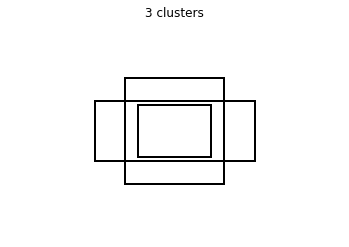

In [ ]:
wcss = []
fig, ax = plt.subplots(1,1)
idx = 0

n_clusters = 3
# ax = axes[idx]

anchors_ = boxes
# anchors = sorted(anchors_, key=lambda x: x[0]*x[1])
# print(anchors)
anchors = boxes
ax.set_title('{} clusters'.format(n_clusters))
ax.axis('off')

for i in range(0, n_clusters):
    ax.add_patch(Rectangle((-1*anchors[i][0]/2 + 0.5, -1*anchors[i][1]/2 + 0.5), anchors[i][0], anchors[i][1], fill=False, linewidth=2))
    # ax.add_patch(Rectangle((0, 0), anchors[i][0], anchors[i][1],color=plt.cm.RdYlBu(i*40)))
idx = idx + 1
